In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# Loading camera calibration
cameraCalibration = pickle.load( open('./camera_cal/cam_calib_pickle.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

# Load perspective transformed images
persptransform_images=pickle.load(open('./camera_cal/persptransform_images.p','rb'))
print(np.array(persptransform_images).shape)

# Load transformation matrix
transMatrix = pickle.load( open('./camera_cal/perspective_transform.p', 'rb' ) )
M, Minv = map(transMatrix.get, ('M', 'Minv'))

(8, 720, 1280, 3)


In [3]:
#Load test images
test_image_files = glob.glob('./test_images/*.jpg')
print("{} Test images loaded".format(len(test_image_files)))

test_images=[]

for f in test_image_files:
    t=cv2.imread(f)
    t=cv2.cvtColor(np.array(t), cv2.COLOR_BGR2RGB)
    test_images.append(t)

8 Test images loaded


In [4]:
def showImages(images, cols = 4, rows = 5, figsize=(15,10), cmap=None):
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax,indx in zip(axes.flat,indexes):
            image = images[indx]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(test_image_files[indx])
#showImages(persptransform_images, 2, 4, (15, 13))
#showImages(test_images, 2, 4, (15, 13))

In [5]:

# Image processing pipeline
# Based on the images above, the S channel (index 2) returns the lanes more reliably
# Undistort and change color space to HLS
def undistandHLS(img, mtx=mtx,dist=dist):
    undist=cv2.undistort(img,mtx,dist,None,mtx)
    return cv2.cvtColor(undist,cv2.COLOR_RGB2HLS)

def sChannelImg(img): 
    #print(np.array(img).shape)
    img=undistandHLS(img)
    return img[:,:,1]

def lChannelImg(img): 
    #print(np.array(img).shape)
    img=undistandHLS(img)
    return img[:,:,2]

# This applies any threshold to an image
def thresholdimg(img, minthresh,maxthresh):
    img_binary=np.zeros_like(img)
    img_binary[(img>=minthresh) &(img<=maxthresh)]=1
    return img_binary

def sobelimg(img, xory='x', sobel_kernel=3,minthresh=0, maxthresh=255):
    if xory=='x':
        ord1=0
        ord2=1
    else:
        ord1=1
        ord2=0
    
    sobel=cv2.Sobel(img, cv2.CV_64F, ord1, ord2, ksize=sobel_kernel)
    abs_sobel=np.absolute(sobel)
    scaled=np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    return thresholdimg(scaled,minthresh, maxthresh)

def gradients(img,minthresh=0, maxthresh=255):
    imgs=sChannelImg(img)
    imgl=lChannelImg(img)
    imgsl=imgs+imgl
    
    sobelX = sobelimg(imgsl, 'x',3,minthresh,maxthresh)
    sobelY = sobelimg(imgsl, 'y',3,minthresh,maxthresh)
    combined = np.zeros_like(sobelX)
    combined [(sobelX == 1) & (sobelY ==1)] = 1
    return combined


# Image processing pipeline
# Based on the images above, the S channel (index 2) returns the lanes more reliably
# Undistort and change color space to HLS

# This applies any threshold to an image
def gradients(img,minthresh=0, maxthresh=255):
    undist=cv2.undistort(img,mtx,dist,None,mtx)
    img=cv2.cvtColor(undist,cv2.COLOR_RGB2HLS)
    imgs=img[:,:,2]
    imgl=img[:,:,2]
    
    sbinary = np.zeros_like(imgs)
    sbinary[(imgs >= 120) & (imgs <= 255)] = 1
    
    lbinary = np.zeros_like(imgl)
    lbinary[(imgl >= 40) & (imgl <= 255)] = 1
    
    sobelx = cv2.Sobel(imgl, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= minthresh) & (scaled_sobel <= maxthresh)] = 1
    
    channels = 255*np.dstack(( imgl, sxbinary, imgs)).astype('uint8')        
    binary = np.zeros_like(sxbinary)
    binary[((imgl == 1) & (imgs == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')
    return binary


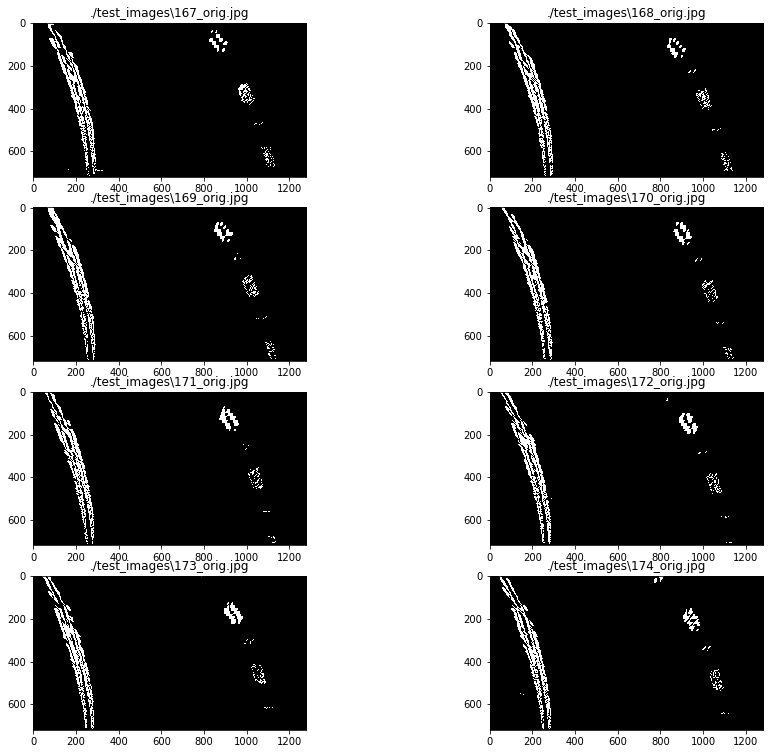

In [7]:
# Combine perspective transform and color transform
colorandpersp_images = []

for img in test_images:
    img1=gradients(img,30,255)
    img_size = (img1.shape[1], img1.shape[0])
    img = cv2.warpPerspective(img1, M, img_size)
    colorandpersp_images.append(img)

showImages(colorandpersp_images, 2, 4, (15, 13),cmap='gray')

In [7]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def determinelanes(binary_warped):

    #binary_warped=colorandpersp_images[2]
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, ploty, left_curverad, right_curverad, left_fit, right_fit

def unwarpimg(img, left_fit, right_fit):
    
    yMax = img.shape[0]
    yvals = np.linspace(0, yMax - 1, yMax)
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #undist = undistort(img)    
    #unwarp,Minv = warp(img,tobird=False)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result 


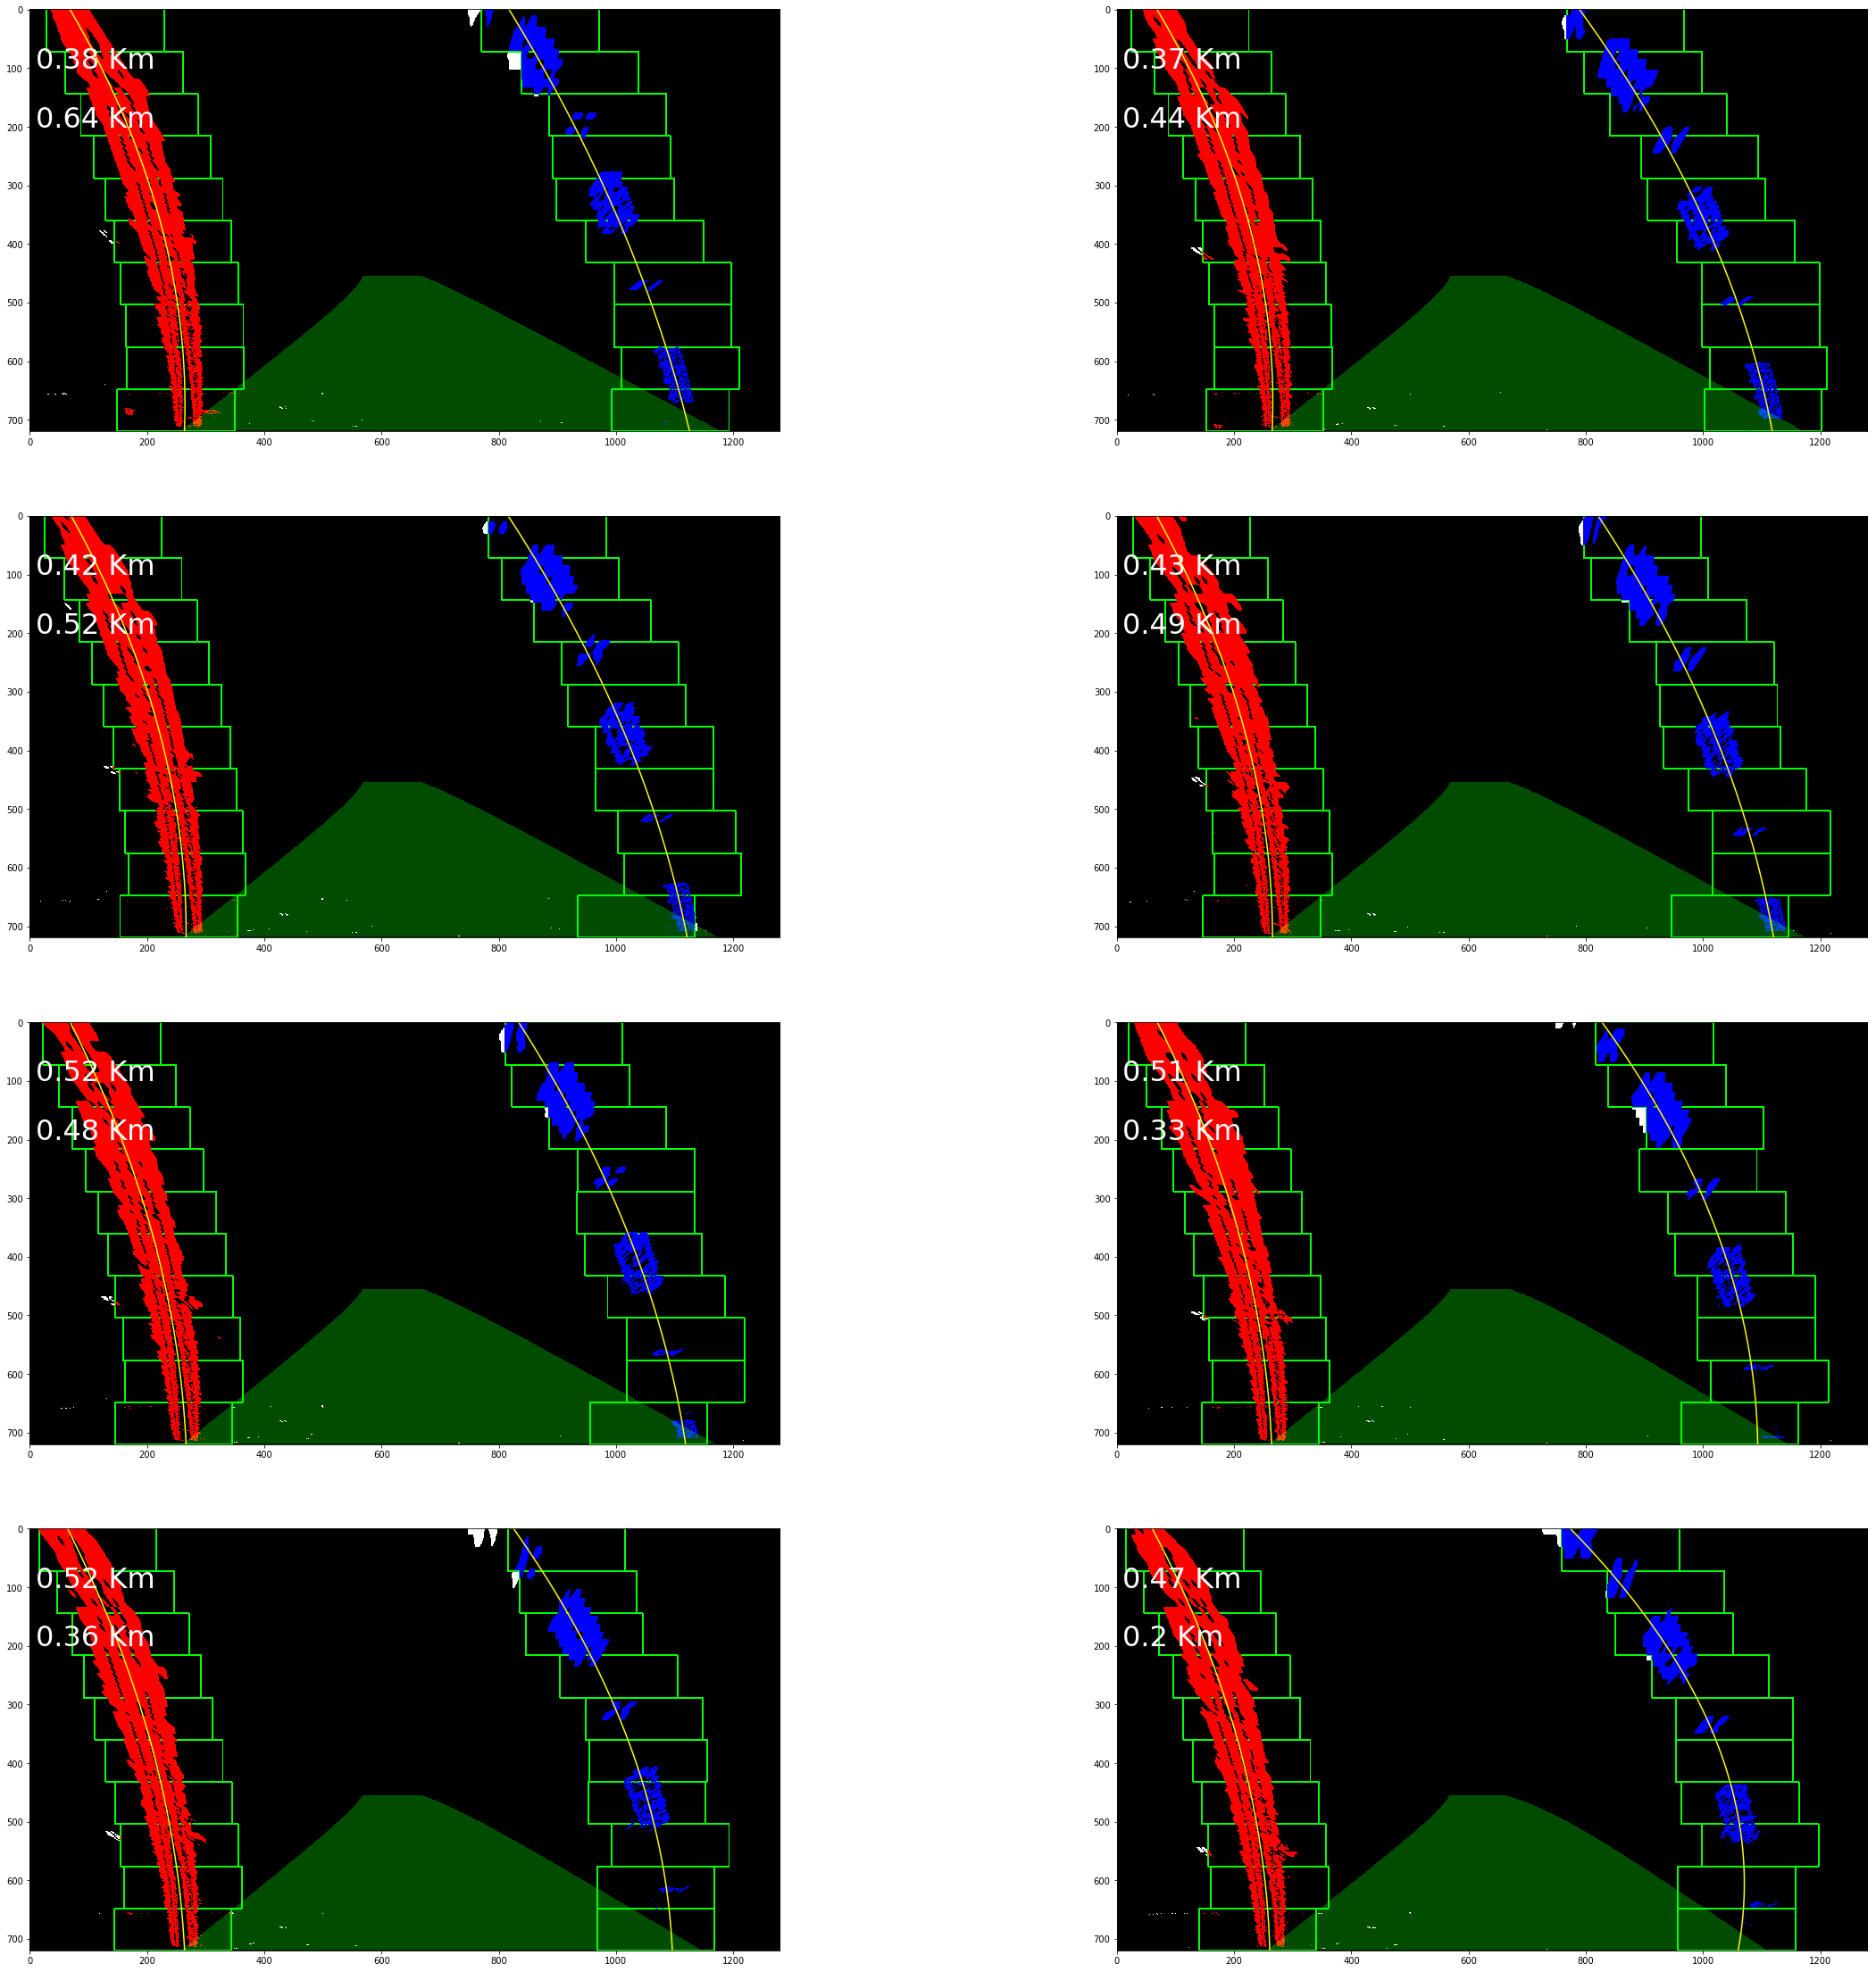

In [8]:
cols=4
rows=2
fig, axes = plt.subplots(cols, rows, figsize=(40,40))
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):
    test_image = test_images[index]
    img=gradients(test_image ,10,160)
    img_size = (img.shape[1], img.shape[0])
    img = cv2.warpPerspective(img, M, img_size)
    out_img, left_fitx, right_fitx, ploty, left_curverad, right_curverad, \
    left_fit, right_fit = determinelanes(img)
    #result = unwarpimg(test_image, left_fit, right_fit)
    result = unwarpimg(out_img, left_fit, right_fit)  # Uncomment and comment line 12
    ax.imshow(result)
    ax.plot(left_fitx, ploty, color='yellow')         # Uncomment and comment line 12
    ax.plot(right_fitx, ploty, color='yellow')        # Uncomment and comment line 12
    ax.text(10,100,str(round(left_curverad/1000,2))+' Km',fontsize=32, color='white')
    ax.text(10,200,str(round(right_curverad/1000,2))+' Km',fontsize=32, color='white')


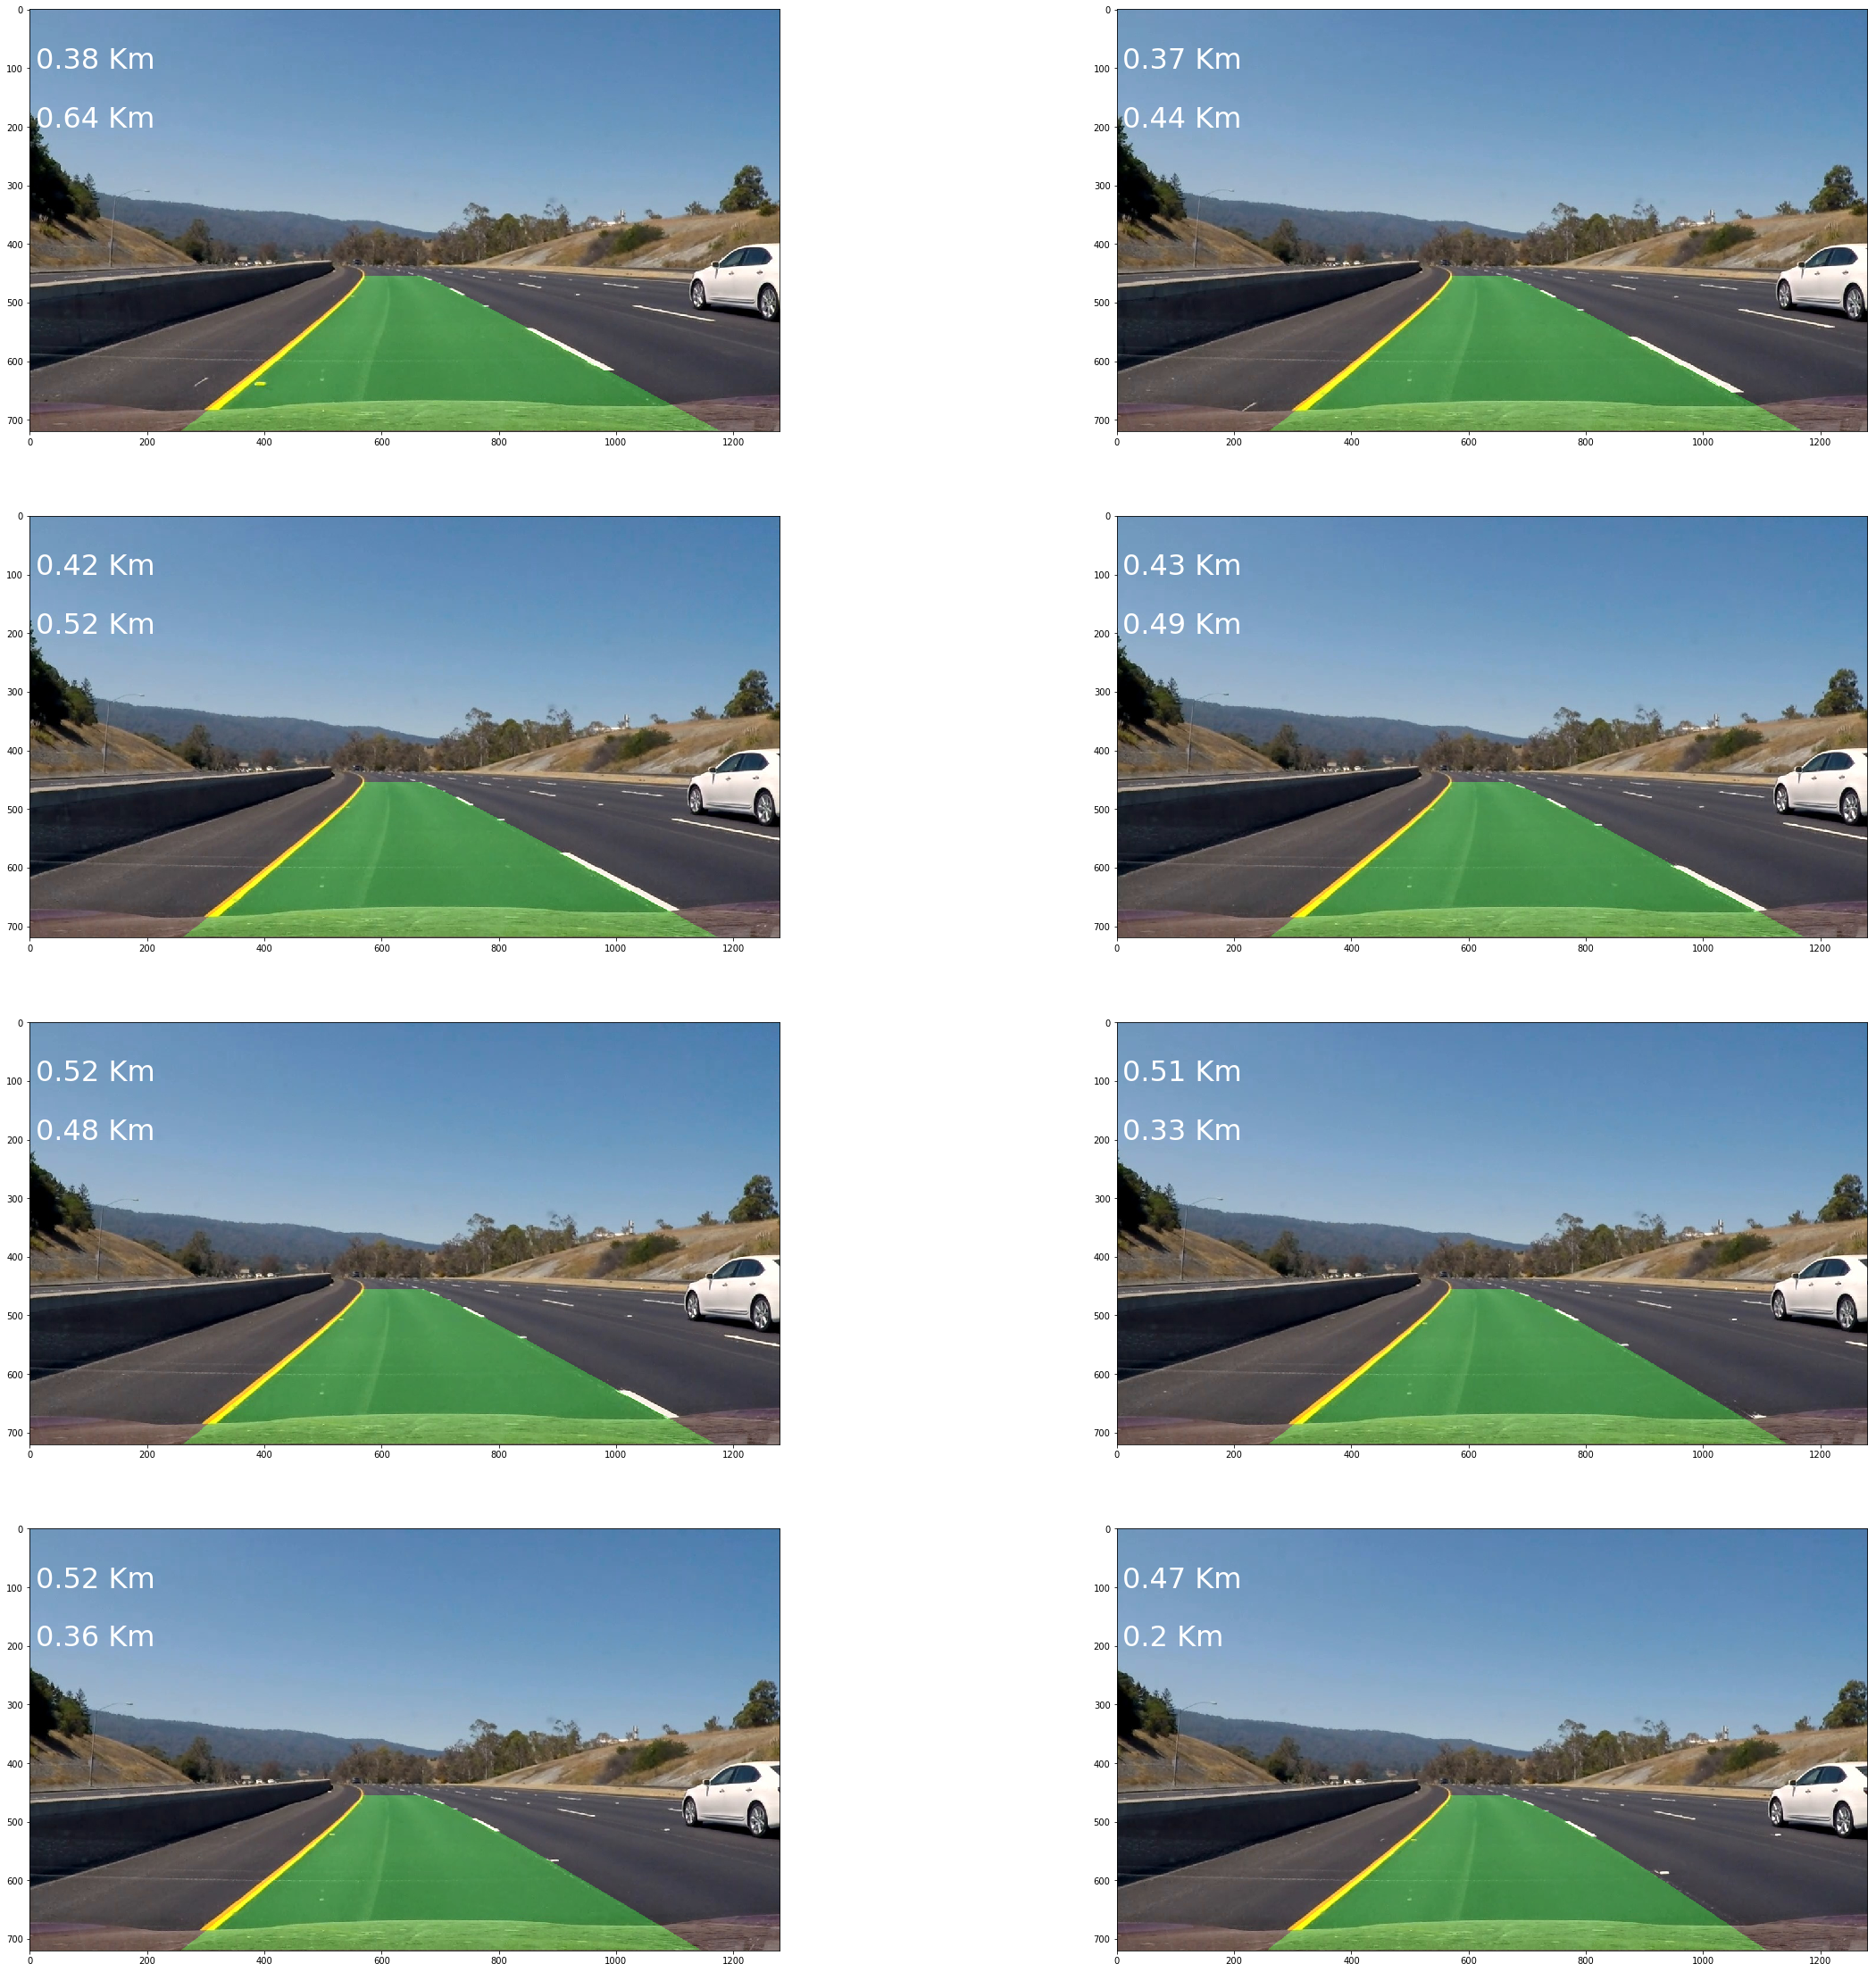

In [9]:
cols=4
rows=2
fig, axes = plt.subplots(cols, rows, figsize=(40,40))
indexes = range(cols * rows)
for ax, index in zip(axes.flat, indexes):
    test_image = test_images[index]
    img=gradients(test_image ,10,160)
    img_size = (img.shape[1], img.shape[0])
    img = cv2.warpPerspective(img, M, img_size)
    out_img, left_fitx, right_fitx, ploty, left_curverad, right_curverad, \
    left_fit, right_fit = determinelanes(img)
    result = unwarpimg(test_image, left_fit, right_fit)
    #result = unwarpimg(out_img, left_fit, right_fit)  # Uncomment and comment line 12
    ax.imshow(result)
    #ax.plot(left_fitx, ploty, color='yellow')         # Uncomment and comment line 12
    #ax.plot(right_fitx, ploty, color='yellow')        # Uncomment and comment line 12
    ax.text(10,100,str(round(left_curverad/1000,2))+' Km',fontsize=32, color='white')
    ax.text(10,200,str(round(right_curverad/1000,2))+' Km',fontsize=32, color='white')
